# Compare E4CV 4-circle orientation with SPEC fourc

Following the E4CV example (consult the example for geometry
details), compare the orientation matix and
positioning operations with **hklpy** (and **libhkl**) and **SPEC**.

Information from a **SPEC** data file will be used for the comparison.

----

Note:  This example is available as a
[Jupyter notebook](https://jupyter.org/) from the **hklpy** source
code website: https://github.com/bluesky/hklpy/tree/main/examples

In SPEC *fourc* geometry (https://certif.com/spec_help/fourc.html):

name    | mnemonic   | description
-----   | -----      | -----
2theta  | tth        | Detector arm rotation
Omega   | om         | Rotates sample circles
Chi     | chi        | Sample tilt
Phi     | phi        | Sample rotation

The provided SPEC data file names these motors: `tth`, `th`, `chi`, `phi`
so this example will use the same names to help the comparison.

In [1]:
# mapping of axis names between hklpy and SPEC
AXIS_NAME_MAP = dict(
    # E4CV  fourc
    tth='tth',   # Detector arm rotation
    omega='th',  # Rotates chi around horizontal axis
    chi='chi',   # TODO: Rotates phi around beam axis  # TODO: is this correct?
    phi='phi',   # Sample rotation around horizontal axis (when phi is co-linear with omega)
)

## Read the SPEC scan from the data file

The SPEC file provides all the information needed here.  The
[*spec2nexus*](https://github.com/prjemian/spec2nexus) 
(python) package can read the file and parse the content into useful 
structures, including deducing the diffractometer geometry in many cases.

In [2]:
import pyRestTable
from spec2nexus.spec import SpecDataFile

specfile = SpecDataFile("resources/LNO_LAO_s14.dat")
specscan = specfile.getScan(14)

spec_d = specscan.diffractometer
spec_d.UB = spec_d.geometry_parameters["ub_matrix"][2]

terms = {
    "SPEC file": specfile.specFile,
    "scan #": specscan.scanNum,
    "SPEC scanCmd": specscan.scanCmd,
    "geometry": spec_d.geometry_name,
    "mode": spec_d.mode,
    "lattice": spec_d.lattice,
    "wavelength": spec_d.wavelength,
    "reflection 1": spec_d.reflections[0],
    "reflection 2": spec_d.reflections[1],
    "[UB]": spec_d.UB,
}
tbl = pyRestTable.Table()
tbl.labels = "term value".split()
for k, v in terms.items():
    tbl.addRow((k, v))
print(tbl)

============ =======================================================================================================================================================
term         value                                                                                                                                                  
============ =======================================================================================================================================================
SPEC file    LNO_LAO                                                                                                                                                
scan #       14                                                                                                                                                     
SPEC scanCmd hklscan  1.00133 1.00133  1.00133 1.00133  2.85 3.05  200 -400000                                                                                      
geometry  

## Plot the (_hkl_) trajectories in the scan

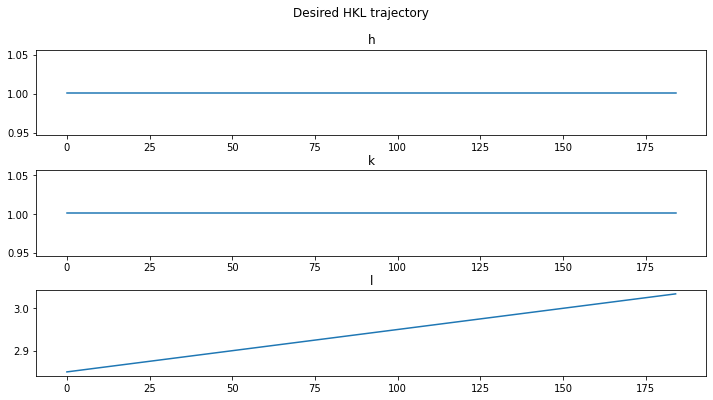

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# plot the h, k, & l vs. point number
fig, axes = plt.subplots(3, 1, figsize=(12, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

plt.suptitle('Desired HKL trajectory')
axes[0].plot(specscan.data["H"])
axes[0].set_title("h")
axes[1].plot(specscan.data["K"])
axes[1].set_title("k")
axes[2].plot(specscan.data["L"])
axes[2].set_title("l")
plt.show()

## Setup the *E4CV* diffractometer in *hklpy*

In [4]:
import gi
gi.require_version('Hkl', '5.0')
from hkl import SimulatedE4CV
from hkl import Lattice

Use the `hkl.geometries.SimulatedE4CV()` class.  All is prebuilt.

In [5]:
class Diffractometer(SimulatedE4CV):
    pass

In [6]:
fourc = Diffractometer("", name="fourc")
fourc.calc.physical_axis_names = {
    # E4CV: local
    'omega': 'th',
    'chi': 'chi',
    'phi': 'phi',
    'tth': 'tth',
    }


In [7]:
# add the sample to the calculation engine
fourc.calc.new_sample(
    specfile.specFile,
    lattice=Lattice(
        a=spec_d.lattice.a, 
        b=spec_d.lattice.b, 
        c=spec_d.lattice.c,
        alpha=spec_d.lattice.alpha, 
        beta=spec_d.lattice.beta, 
        gamma=spec_d.lattice.gamma)
    )

HklSample(name='LNO_LAO', lattice=LatticeTuple(a=3.781726143, b=3.791444574, c=3.79890313, alpha=90.2546203, beta=90.01815424, gamma=89.89967858), ux=Parameter(name='None (internally: ux)', limits=(min=-180.0, max=180.0), value=0.0, fit=True, inverted=False, units='Degree'), uy=Parameter(name='None (internally: uy)', limits=(min=-180.0, max=180.0), value=0.0, fit=True, inverted=False, units='Degree'), uz=Parameter(name='None (internally: uz)', limits=(min=-180.0, max=180.0), value=0.0, fit=True, inverted=False, units='Degree'), U=array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), UB=array([[ 1.66146225e+00, -2.89938471e-03,  5.11196668e-04],
       [ 0.00000000e+00,  1.65721725e+00,  7.34922202e-03],
       [ 0.00000000e+00,  0.00000000e+00,  1.65394723e+00]]), reflections=[])

## Test *hklpy* with the **UB** orientation matrix from **SPEC**

Using the UB matrix as provided in the SPEC data file, 
compute the forward reflection positions and compare with
those calculated by **libhkl**.

In [8]:
# get the UB matrix from the SPEC data
# SPEC's UB first row moved (via numpy slicing) to last row for hklpy
fourc.UB.put(spec_d.UB[[1,2,0], :])
print(spec_d.UB)
print(fourc.UB.get())

# calculate angles with hklpy using the SPEC UB matrix
fourc.engine.mode = "bissector"
fourc.calc["phi"].limits = (-50, 100)
fourc.calc["tth"].limits = (-2, 180)
print("(002) :", fourc.forward((0, 0, 2)))
print("(113) :", fourc.forward((1, 1, 3)))

[[-1.65871244e+00  9.82002413e-02 -3.89705578e-04]
 [-9.55499031e-02 -1.65427863e+00  2.42844486e-03]
 [ 2.62981891e-04  9.81574682e-03  1.65396181e+00]]
[[-9.55499053e-02 -1.65427875e+00  2.42825603e-03]
 [ 2.63161907e-04  9.81566638e-03  1.65396189e+00]
 [-1.65871254e+00  9.82003048e-02 -3.89644168e-04]]
(002) : PosCalcE4CV(th=23.915206114843723, chi=89.91480547663718, phi=99.11611601433698, tth=47.83041222968745)
(113) : PosCalcE4CV(th=42.33129428600625, chi=115.20291094237979, phi=48.133061440101486, tth=84.6625885720125)


Define a custom reporting function to format the output table.

In [9]:
def add_ref_to_table(tbl, r):
    sol = fourc.forward((r.h, r.k, r.l))
    nm = f"{r.h:.0f} {r.k:.0f} {r.l:.0f}"
    # print(nm, sol)
    for sm in AXIS_NAME_MAP.values():
        row = [f"({nm})", sm]
        v_hklpy = getattr(sol, sm)
        v_spec = r.angles[sm]
        row.append(f"{v_hklpy:.5f}")
        row.append(f"{v_spec:.5f}")
        row.append(f"{v_hklpy-v_spec:.5f}")
        tbl.addRow(row)

For each of the orientation reflections used in the SPEC file,
report the computed motor positions for each reflection for 
E4CV and SPEC.  We'll only pick positions where $2\theta\ge 0$.

In [10]:
# Compare these angles with those from SPEC

tbl = pyRestTable.Table()
tbl.labels = "(hkl) motor E4CV SPEC difference".split()
r1, r2 = spec_d.reflections

fourc.engine.mode = "bissector"
fourc.calc["tth"].limits = (-2, 180)
add_ref_to_table(tbl, r1)

# print(r2)
add_ref_to_table(tbl, r2)

print(tbl)

======= ===== ========= ========= ==========
(hkl)   motor E4CV      SPEC      difference
======= ===== ========= ========= ==========
(0 0 2) tth   47.83041  38.09875  9.73166   
(0 0 2) th    23.91521  19.13350  4.78171   
(0 0 2) chi   89.91481  90.01350  -0.09869  
(0 0 2) phi   99.11612  0.00000   99.11612  
(1 1 3) tth   84.66259  65.64400  19.01859  
(1 1 3) th    42.33129  32.82125  9.51004   
(1 1 3) chi   115.20291 115.23625 -0.03334  
(1 1 3) phi   48.13306  48.13150  0.00156   
======= ===== ========= ========= ==========



Note that the angles do not match between *E4CV* and *SPEC*,
even if we re-arrange the rows as we did above.  Can't just
use the UB matrix from the one program in the other
software.

Need to add the orientation reflections (with wavelength),
then compute the UB matrix.  Follow in the section below.

## Setup the **UB** orientation matrix using *hklpy*

Compute the UB matrix using *hklpy* (& *libhkl*).

In [11]:
fourc.calc.wavelength = 1.239424258  # Angstrom

refs = [
    fourc.calc.sample.add_reflection(
        r.h, r.k, r.l, 
        position=fourc.calc.Position(
            tth=r.angles["tth"],
            th=r.angles["th"],
            chi=r.angles["chi"],
            phi=r.angles["phi"],
        )
    )
    for r in spec_d.reflections
]

fourc.calc.sample.compute_UB(*refs)

tbl = pyRestTable.Table()
tbl.labels = "term value".split()
tbl.addRow(("SPEC [UB]", spec_d.UB))
tbl.addRow(("E4CV [UB]", fourc.UB.get()))
print(tbl)

========= ===================================================
term      value                                              
========= ===================================================
SPEC [UB] [[-1.65871244e+00  9.82002413e-02 -3.89705578e-04] 
           [-9.55499031e-02 -1.65427863e+00  2.42844486e-03] 
           [ 2.62981891e-04  9.81574682e-03  1.65396181e+00]]
E4CV [UB] [[-9.55498634e-02 -1.65427875e+00  2.42844498e-03] 
           [ 2.63111155e-04  9.81585901e-03  1.65396189e+00] 
           [-1.65871254e+00  9.82002627e-02 -3.89705597e-04]]
========= ===================================================



Report the results, as before, and compare with table above.

In [12]:
tbl = pyRestTable.Table()
tbl.labels = "term value".split()
tbl.addRow(("energy, keV", fourc.calc.energy))
tbl.addRow(("wavelength, angstrom", fourc.calc.wavelength))
tbl.addRow(("position", fourc.position))
tbl.addRow(("sample name", fourc.sample_name.get()))
tbl.addRow(("[U]", fourc.U.get()))
tbl.addRow(("[UB]", fourc.UB.get()))
tbl.addRow(("lattice", fourc.lattice.get()))
print(tbl)

print(f"sample\t{fourc.calc.sample}")

==================== =========================================================================
term                 value                                                                    
==================== =========================================================================
energy, keV          10.003370290659586                                                       
wavelength, angstrom 1.239424258                                                              
position             DiffractometerPseudoPos(h=-0.0, k=0.0, l=0.0)                            
sample name          LNO_LAO                                                                  
[U]                  [[-5.75094968e-02 -9.98327391e-01  5.92267768e-03]                       
                      [ 1.58361191e-04  5.92337392e-03  9.99982444e-01]                       
                      [-9.98344947e-01  5.75094251e-02 -1.82553939e-04]]                      
[UB]                 [[-9.55498634e-02 -1.65427875

In [13]:
# Compare these angles with those from SPEC
# fourc.calc["phi"].limits = (-1, 100)
tbl = pyRestTable.Table()
tbl.labels = "(hkl) motor E4CV SPEC difference".split()
r1, r2 = spec_d.reflections
fourc.calc["tth"].limits = (-2, 180)

fourc.engine.mode = "constant_phi"
fourc.phi.move(0)
add_ref_to_table(tbl, r1)

fourc.engine.mode = "bissector"
add_ref_to_table(tbl, r2)

print(tbl)

======= ===== ========= ========= ==========
(hkl)   motor E4CV      SPEC      difference
======= ===== ========= ========= ==========
(0 0 2) tth   38.08407  38.09875  -0.01468  
(0 0 2) th    19.12616  19.13350  -0.00734  
(0 0 2) chi   90.01350  90.01350  -0.00000  
(0 0 2) phi   0.00000   0.00000   0.00000   
(1 1 3) tth   65.63700  65.64400  -0.00700  
(1 1 3) th    32.81850  32.82125  -0.00275  
(1 1 3) chi   115.20291 115.23625 -0.03334  
(1 1 3) phi   48.13305  48.13150  0.00155   
======= ===== ========= ========= ==========

